In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing import sequence
import random
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import unicodedata
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')

In [3]:
texts = df.content.to_list()

In [4]:
num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1

In [5]:
maxlen = 1500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [6]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [7]:
X.shape, X.nbytes * 1e6

((2225, 1500, 1000), 3337500000000000.0)

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
import keras 
#RMSprop(learning_rate=0.01)

recurrent_encoder = keras.models.Sequential([
    keras.layers.Embedding(num_words+1, 64, input_length=maxlen),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(maxlen, input_shape=[32]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="softmax")),
    keras.layers.Flatten(),
    
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss='mse', optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
                     metrics=[rounded_accuracy])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                109504    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1500)              8353      
Total params: 117,857
Trainable params: 117,857
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = recurrent_ae.fit(sequences, sequences, epochs=10)

Epoch 1/10
70/70 [==============================] - 165s 2s/step - loss: 15844.5703 - rounded_accuracy: 0.0736
Epoch 2/10
70/70 [==============================] - 175s 2s/step - loss: 15844.5713 - rounded_accuracy: 0.0736
Epoch 3/10
70/70 [==============================] - 169s 2s/step - loss: 15844.5732 - rounded_accuracy: 0.0736
Epoch 4/10
70/70 [==============================] - 167s 2s/step - loss: 15844.5703 - rounded_accuracy: 0.0736
Epoch 5/10
70/70 [==============================] - 169s 2s/step - loss: 15844.5713 - rounded_accuracy: 0.0736
Epoch 6/10
70/70 [==============================] - 169s 2s/step - loss: 15844.5732 - rounded_accuracy: 0.0736
Epoch 7/10
70/70 [==============================] - 167s 2s/step - loss: 15844.5732 - rounded_accuracy: 0.0736
Epoch 8/10
70/70 [==============================] - 172s 2s/step - loss: 15844.5713 - rounded_accuracy: 0.0736
Epoch 9/10
70/70 [==============================] - 177s 3s/step - loss: 15844.5732 - rounded_accuracy: 0.0736
E

In [11]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(2225, 32)


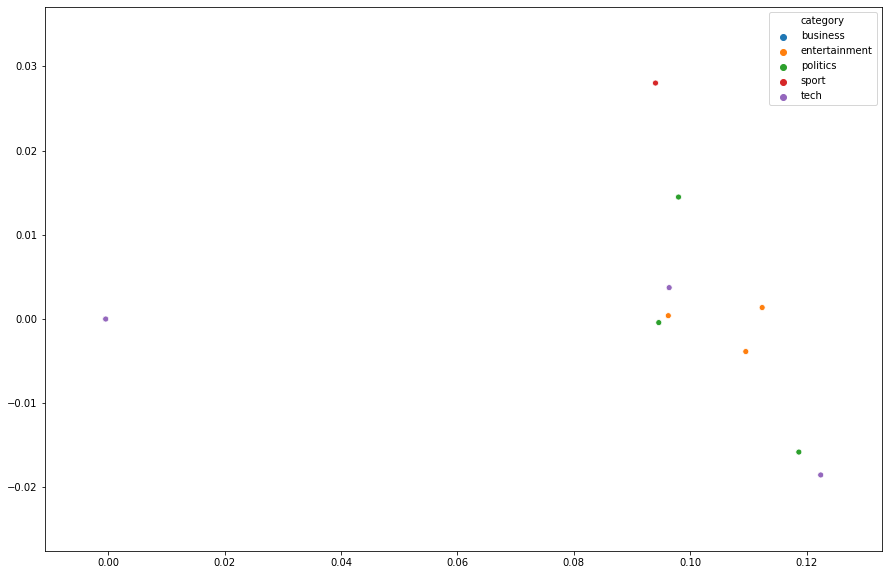

In [12]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

plt.figure(figsize=(15,10))
r = PCA(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)